In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpyro
import jax.numpy as jnp
import numpyro.optim as optim
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.distributions import constraints
from jax import lax
from jax.random import PRNGKey

# Single Level Model
In our simplest model, we will just model each post.

# Data

First, we load the Reddit datasets

In [2]:
comments = dict()
with open('../data/results/Comments.json') as f:
    for line in f:
        post = json.loads(line)
        comments[post['pid']] = post['api_num_comments'], post['comments']

In [3]:
corrections = []
with open('../data/results/CorrectionPairs.json') as f:
    for line in f:
        corrections.append(json.loads(line))

In [4]:
news = []
with open('../data/results/NewsPairs.json') as f:
    for line in f:
        news.append(json.loads(line))

Gather relevant variables

In [5]:
def processData(data, items, comments, minutes=60, offset=0):
    for idx, n in enumerate(items):
        i = idx + offset
        
        isNews = 'isFakeStory' in n['r']['reviewRating']
        news_id = n['p']['id']
        
        num_cmts, cmts = comments[news_id]
        c_body_lens = []
        c_ups = []
        c_downs = []
        unique_authors = set()
        for c in cmts:
            # skip if comment not created in first _ mins
            if c['delta_seconds'] > minutes * 60:
                continue

            c_minutes = c['delta_seconds'] / 60
            if c_minutes <= minutes:   # cmts in first _ mins
                data[i, 7] += 1
            
            c_body_lens.append(c['body_len'])
            c_ups.append(c['ups'])
            c_downs.append(c['downs'])
            
            if c['author']:
                unique_authors.add(c['author'])

        data[i, 0] = num_cmts
        if isNews:
            data[i, 1] = 1 if n['r']['reviewRating']['isFakeStory'] else 0
        else:
            data[i, 1] = 3 if n['r']['reviewRating']['isFakeClaim'] else 2
        data[i, 2] = np.mean(c_body_lens) if c_body_lens else 0.
        data[i, 3] = np.std(c_body_lens) if c_body_lens else 0.
        data[i, 4] = np.mean(c_ups) if c_ups else 0.
        data[i, 5] = np.std(c_ups) if c_ups else 0.
        data[i, 6] = len(unique_authors) if unique_authors else 0.
    return data

In [6]:
num_p_indep = 8
data = np.zeros((len(news) + len(corrections), num_p_indep))

data = processData(data, news, comments)
data = processData(data, corrections, comments, offset=len(news))

Variables (in order):

0. num_comments
1. type
2. comment_length_avg
3. comment_length_std
4. comment_upvotes_avg
5. comment_upvotes_std
6. num_unique_comment_authors
7. num_comments in first _ mins

In [7]:
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors
t_data = data[:,1].reshape(-1,1)
biases = np.ones_like(t_data)

In [8]:
# select relevant indep vars
p_data = data[:, (2,4,6,7)]  # avg cmt length, avg upvotes, num authors, num initial comments
# p_data = data[:,7].reshape(-1,1)  # num comments in 1st hr
t_data = data[:,1].reshape(-1,1)

# add bias terms
biases = np.ones_like(t_data)
p_data = np.concatenate((biases, p_data), axis=1)
t_data = np.concatenate((biases, t_data), axis=1)

# get dep var
y = data[:,0].reshape(-1,1)

split into train/test

In [9]:
train_frac = 0.7
num_obs = p_data.shape[0]
idx = np.random.binomial(1, train_frac, size=num_obs).astype(bool)

p_data_train = p_data[idx,:]
p_data_test = p_data[~idx,:]

y_train = y[idx,:]
y_test = y[~idx,:]

-----

# Modeling

Cast data to jax numpy arrays (immutable)

In [10]:
p_data_train = jnp.array(p_data_train)
p_data_test = jnp.array(p_data_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)

Post-Level Regression

y_p = phi_0 * bias + phi_1 * first_hour_comments + epsilon

In [11]:
def model(p_data, y):
    num_posts, num_p_indeps = p_data.shape

    # define a prior for our regression variables
    phi_prior = dist.Normal(jnp.zeros((num_p_indeps, 1)),
                            10. * jnp.ones((num_p_indeps, 1)))  # (num_p_indeps, 1)
    phi = numpyro.sample("phi", phi_prior)  # (num_p_indeps, 1)
    
#    sigma_prior = dist.HalfNormal(1.)
#    sigma = numpyro.sample("sigma", sigma_prior)
    sigma = numpyro.sample("sigma", dist.Uniform(0., 1000.))

    # for each post, use the correct set of coefficients to run our post-level regression
    with numpyro.plate("post", num_posts, dim=-1) as p:

        # indep vars for this post
        indeps = p_data[p,:]  # (num_posts, num_p_indeps)
        
        # calculate the mean
        mu = jnp.matmul(indeps, phi)  # (num_posts, num_p_indeps) (num_p_indeps, 1)
        
        # sample
        return numpyro.sample("obs", dist.Normal(mu, sigma), obs=y[p])  # (num_posts, 1)

In [12]:
def guide(p_data, y):
    num_posts, num_p_indeps = p_data.shape
    
    phi_loc = numpyro.param("phi_loc", jnp.zeros((num_p_indeps, 1)))
    phi_scale = numpyro.param("phi_scale", jnp.ones((num_p_indeps, 1)), 
                              constraint=constraints.positive)
    
    #sigma_scale = numpyro.param("sigma_scale", 1.)
    sigma_loc = numpyro.param('sigma_loc', jnp.array(1.),
                             constraint=constraints.positive)
    
    # define a prior for our regression variables
    phi_prior = dist.Normal(phi_loc, phi_scale)  # (num_p_indeps, 1)
    phi = numpyro.sample("phi", phi_prior)  # (num_p_indeps, 1)
    
#    sigma_prior = dist.HalfNormal(sigma_scale)
    sigma = numpyro.sample("sigma", dist.Normal(sigma_loc, jnp.array(0.05)))
#    sigma = numpyro.sample("sigma", sigma_prior)

# Inference

In [13]:
svi = SVI(model,
          guide,
          optim.Adam(step_size=.1),
          loss=Trace_ELBO())

num_iters = 1000
rng_key = PRNGKey(1)
init_state = svi.init(rng_key, p_data_train, y_train)
#state = lax.fori_loop(0, num_iters, lambda i, state: svi.update(state, p_data_train, y_train)[0], init_state)
state, losses = lax.scan(lambda state, i: svi.update(state, p_data_train, y_train), init_state, jnp.arange(num_iters))

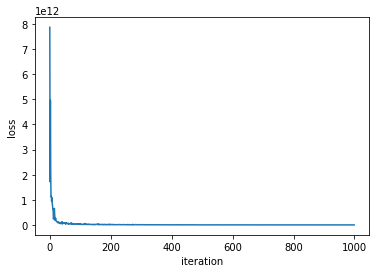

In [14]:
plt.plot(range(len(losses)), np.array(losses))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

In [15]:
params = svi.get_params(state)
params

{'phi_loc': DeviceArray([[1.8933758 ],
              [0.07032824],
              [3.5912144 ],
              [3.5696852 ],
              [3.7546175 ]], dtype=float32),
 'phi_scale': DeviceArray([[1.1100756 ],
              [0.20386064],
              [0.56423366],
              [0.45012054],
              [0.45010695]], dtype=float32),
 'sigma_loc': DeviceArray(18.345049, dtype=float32)}

In [16]:
num_samples = 10
predictive = Predictive(model, guide=guide, params=params, num_samples=num_samples)
y_pred = predictive(rng_key, p_data=p_data_test, y=y_test)["obs"].copy()

In [17]:
for i in range(num_samples):
    if not np.alltrue(np.array(y_pred[0]) == np.array(y_test)):
        print(i)

In [18]:
y_pred[0]

array([[132.],
       [  0.],
       [  0.],
       ...,
       [ 10.],
       [  3.],
       [  0.]], dtype=float32)

In [19]:
y_test

DeviceArray([[132.],
             [  0.],
             [  0.],
             ...,
             [ 10.],
             [  3.],
             [  0.]], dtype=float32)

## some MCMC experiments

In [20]:
from numpyro.infer import MCMC, NUTS, Predictive

In [ ]:
kernel = NUTS(model)

num_iters = 1000
rng_key = PRNGKey(1)
mcmc = MCMC(kernel, num_warmup=500, num_samples=num_iters, num_chains=1, chain_method="parallel")
mcmc.run(rng_key, p_data_train, y_train)

warmup:   2%|▏         | 34/1500 [05:08<15:30:23, 38.08s/it, 255 steps of size 7.17e-10. acc. prob=0.54]

In [ ]:
posterior_samples = mcmc.get_samples()

In [61]:
numpyro.diagnostics.summary(posterior_samples)

NameError: name 'posterior_samples' is not defined

# Evaluation

Check the fit

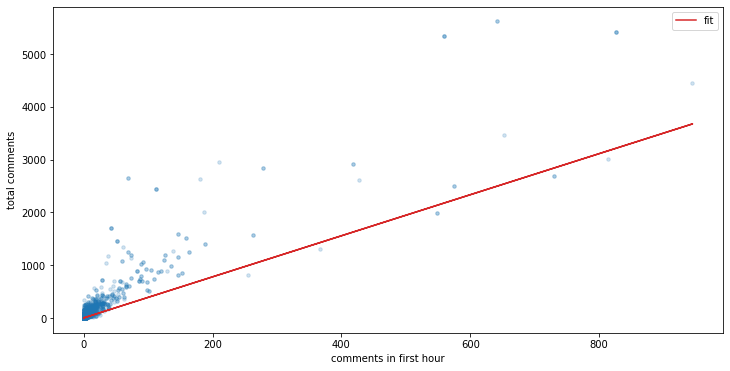

In [65]:
y_pred = params['phi_loc'][0]
#y_pred += params['phi_loc'][1] * p_data[:,1]  # avg cmt length
#y_pred += params['phi_loc'][2] * p_data[:,2]  # avg upvotes
#y_pred += params['phi_loc'][3] * p_data[:,3]  # num authors
y_pred += params['phi_loc'][4] * p_data[:,4]   # num init cmts

plt.figure(figsize=(12,6))
plt.scatter(np.array(p_data[:,4]), np.array(y), alpha=0.2, s=12, c='tab:blue')
plt.plot(np.array(p_data[:,4]), np.array(y_pred), c='tab:red', label='fit')
plt.xlabel('comments in first hour')
plt.ylabel('total comments')
plt.legend()
plt.show()

Interpretation:

- For posts with no comments in the first hour, we expect 7.23 comments in total
- For every comment in the first hour, we expect an additional 6.43 comments in total

Visualize the posterior predictive

In [20]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [21]:
num_samples = 1
predictive = Predictive(model, guide=guide, num_samples=num_samples)

In [22]:
# try this
predictive = Predictive(model, guide=guide, params=params, num_samples=num_samples)
samples = predictive(rng_key=rng_key, p_data=p_data, y=None)

In [30]:
samples['obs']

DeviceArray([[[ 1973.7627  ,  1150.6866  ,  -252.0852  , ...,
                -985.27985 ,   681.9505  ,  -315.42282 ],
              [  520.4189  ,   452.16684 , -1330.2083  , ...,
                1491.6713  , -1535.0989  ,  2169.3516  ],
              [  951.74866 ,   869.421   ,   598.5523  , ...,
                -203.42723 ,  -222.5085  ,   333.6607  ],
              ...,
              [-1205.326   ,   105.08023 ,   708.8266  , ...,
                 377.37637 , -2216.423   ,  1775.2568  ],
              [ -456.15738 ,    22.136986,  -433.57785 , ...,
                -595.1262  ,   316.51868 , -1021.9584  ],
              [ 1156.8049  ,  1656.196   ,   872.6163  , ...,
                -342.76154 ,   645.95953 ,   144.15564 ]]], dtype=float32)

In [33]:
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(rng_key, p_data, None).items()
               if k != "obs"}

In [33]:
predictive = Predictive(svi, guide=guide, num_samples=1000)

# NUMPYRO EXPERIMENT END

----

In [31]:
import arviz as az
data = az.from_numpyro(svi)
az.plot_trace(data, compact=False);

AttributeError: 'SVI' object has no attribute 'get_samples'